<a href="https://colab.research.google.com/github/Csmith715/BERT_NSP/blob/master/Interos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [ ]:
!pip3 install -q tensorflow_gpu==2.2.0

In [ ]:
!pip3 install -q ktrain

In [3]:
import pandas as pd
import numpy as np

import tensorflow
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('topics.csv')
df.head()

,Unnamed: 0,question_text,question_topic
0,0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,1,I'm going to be out of the country for about a...,Shipping
2,2,I was wondering if you'd be able to overnight ...,Shipping
3,3,The Swingline electronic stapler (472555) look...,Shipping
4,4,I think this cosmetic bag would work great for...,Shipping


With any classificaiton task, it is important to know the distribution of the target classes.

In [6]:
df.question_topic.value_counts()

Product Specifications    839
Product Availability      833
Product Comparison        806
Shipping                  799
Returns & Refunds         768
Sales/Promotions          505
Omnichannel               450
Name: question_topic, dtype: int64

In [7]:
df.question_text[0]

"Hi! If I sign up for your email list, can I select to get emails exclusively for sale products? I'm really only interested in shopping clearance deals."

I next will look to see if there are any abnormalities in the questions. For the most part, I am just looking for questions that might be too short or that might be abnormally long.

In [8]:
print('Shortest question: ', min([len(q) for q in df.question_text]))
print('Longest question: ', max([len(q) for q in df.question_text]))

Shortest question:  30
Longest question:  461


# Train Evaluate and Inspect the Model

The first step is to split the data into train/test portions. I decided on an 85/15 split.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.question_text, df.question_topic, test_size=0.15, random_state=22)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

4250
4250
750
750


I also decided to use the bert base model and set the maximum number of tokens to analyze in each question to 65 tokens. As can be seen in the output this well encompasses the majority of the data. If a higher number had been selected, then it is possible that the model would overfit on the padding tokens.

In [23]:
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=65, classes=['Product Specifications','Product Availability','Product Comparison','Shipping','Returns & Refunds','Sales/Promotions','Omnichannel'])
trn = t.preprocess_train(list(X_train), np.array(y_train))
val = t.preprocess_test(list(X_test), np.array(y_test))
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:400: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')
/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:569: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


preprocessing train...
language: en
train sequence lengths:
	mean : 30
	95percentile : 55
	99percentile : 79


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 54
	99percentile : 69


One of the great aspects of the ktrain package is that it allows each researcher the ability to find the optimal learning rate for their deep learning model. This can oftentimes be an arduous task with a lot of guessing.

simulating training for different learning rates... this may take a few moments...
Train for 265 steps
Epoch 1/5
265/265 [==============================] - 80s 304ms/step - loss: 1.8831 - accuracy: 0.2498
Epoch 2/5
265/265 [==============================] - 67s 252ms/step - loss: 0.6215 - accuracy: 0.8961
Epoch 3/5
 46/265 [====>.........................] - ETA: 56s - loss: 0.9816 - accuracy: 0.7014

done.
Visually inspect loss plot and select learning rate associated with falling loss


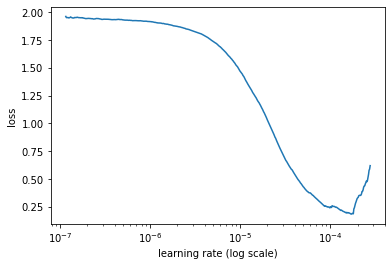

In [24]:
learner.lr_find(show_plot=True, max_epochs=5)

**It should be noted that I had to run this on a colab GPU runtime and limit the number of epochs to 10 due to the time restriction of 3 hours.**

The plot above indicates that an optimal learning rate might be somewhere around 1e-4.



---



---



I will use the learning rate found in the plot above as well as the autofit functionality provided by ktrain. This will help prevent overfitting by observing when the model's loss output stops decreasing.  This will also create a callback point for that state so that the model can be saved in it's most optimal state.

In [26]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Train for 266 steps, validate for 24 steps
Epoch 1/1024
266/266 [==============================] - 75s 281ms/step - loss: 0.3141 - accuracy: 0.8998 - val_loss: 0.1268 - val_accuracy: 0.9680
Epoch 2/1024
266/266 [==============================] - 71s 267ms/step - loss: 0.0787 - accuracy: 0.9840 - val_loss: 0.0993 - val_accuracy: 0.9813
Epoch 3/1024
266/266 [==============================] - 70s 263ms/step - loss: 0.0523 - accuracy: 0.9885 - val_loss: 0.0995 - val_accuracy: 0.9773
Epoch 4/1024
266/266 [==============================] - 70s 264ms/step - loss: 0.0544 - accuracy: 0.9871 - val_loss: 0.0820 - val_accuracy: 0.9840
Epoch 5/1024
266/266 [==============================] - 70s 263ms/step - loss: 0.0344 - accuracy: 0.9920 - val_loss: 0.1123 - val_accuracy: 0.9787
Epoch 6/1024
266/266 [===============

In [27]:
learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

Product Specifications       0.97      0.99      0.98        74
  Product Availability       0.96      0.96      0.96       108
    Product Comparison       0.99      0.98      0.99       130
              Shipping       0.98      0.96      0.97       123
     Returns & Refunds       0.98      0.98      0.98       122
      Sales/Promotions       0.96      1.00      0.98        71
           Omnichannel       1.00      0.99      1.00       122

              accuracy                           0.98       750
             macro avg       0.98      0.98      0.98       750
          weighted avg       0.98      0.98      0.98       750



array([[ 73,   0,   0,   0,   0,   1,   0],
       [  0, 104,   0,   1,   1,   2,   0],
       [  0,   0, 128,   2,   0,   0,   0],
       [  0,   4,   1, 118,   0,   0,   0],
       [  2,   0,   0,   0, 120,   0,   0],
       [  0,   0,   0,   0,   0,  71,   0],
       [  0,   0,   0,   0,   1,   0, 121]])

# Making Predictions on New Data

In [28]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [29]:
test_question1 = 'What is the expected deliverty time for an order placed on a Monday?'
test_question2 = 'How much wood could a woodchuck chuck if a woodchuck could chuck wood?'

predictor.predict(test_question1)

'Shipping'

In [30]:
# A fun prediction.  I guess woodchucks chucking wood constitutes shipping?
predictor.predict(test_question2)

'Shipping'

In [31]:
# predicted probability scores for each category
predictor.predict_proba(test_question1)

array([0.00372046, 0.092062  , 0.01295981, 0.757427  , 0.00256072,
       0.12997694, 0.00129312], dtype=float32)

In [32]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [33]:
# To observe which words influenced the classification of text in the model
predictor.explain(test_question1)

# Discussion

* **What was your approach?**

  For a quick turnaround model like this, I knew I could rely on the ktrain package. It does an excellent job of wrapping a lot of transformer models for quick classification purposes.

* **Where did you draw inspiration from?** 

  I have created a few models with this library before. However, all of them had previously been binary classifcation cases. This was the first that was a multi-label situation.

* **What did you do or try to do that was novel?**

  Given the short assessment time period, there wasn't much I could really do that was novel or different than any other text classification situation. I suppose using the utility to find the optimal learning rate could be considered novel or the autofit tool. However, these are all part of the ktrain package.

  I guess the inflential text that I added at the end is a little unique as well. It certainly helps debug some NLP projects that are overfitting or misclassifying specific texts. 

* **What failed?**

  I initially tried to run this locally on a CPU's. I quickly realized that would take too long and switched to a Google Colab notebook. There I was able to run this on GPU's and accomplish the task much more quickly.

* **What were your results?**

  The results were outstanding!! The accuracy on the test set was 0.98 and the F1 scores were all exceptionally high. 

* **How could your results be improved?**

  It is certainly possible to improve the results by using a cased BERT model or by trying a different learning rate.  However, I think the initial results were fairly impressive. 

* **What would you do if you had another day? Another week? Another month?** 

  Given the initial results. I feel that it would be best to validate this model with more external data. Otherwise, this might be good to go the way it is.

* **How well does your model generalize outside the data provided?**

   In the one test scenario I tested, it seemed to work quite well. This could be futher supported with more testing. 